In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorboard.plugins import projector
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.executing_eagerly()
%load_ext autotime
%load_ext tensorboard

time: 15 ms (started: 2021-05-15 02:39:45 +05:30)


In [2]:
def plot_graphs(hist,metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.legend([metric,'val_'+metric])

time: 0 ns (started: 2021-05-15 02:39:45 +05:30)


In [3]:
buffer_size = 1024
batch_size = 128

data_size = 1600000
trunc_size = data_size//2 # reduced data size
train_size = int(0.7 * trunc_size )

time: 0 ns (started: 2021-05-15 02:39:45 +05:30)


In [4]:

# Create a dictionary describing the features.
image_feature_description = {
    'feature1': tf.io.FixedLenFeature([], tf.int64), # label
    'feature2': tf.io.FixedLenFeature([],tf.string) # text
}

def _parse_function(example_proto):
        
  # Parse the input tf.train.Example proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    label = example['feature1']
    text = example['feature2']
    
    return (text,label)

def get_dataset(filename, set_type): # function to produce dataset
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False # disable native order, increase speed
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.take(trunc_size)
    
    dataset = dataset.with_options(
        ignore_order
    )
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTOTUNE).cache()
    
    if set_type == "train":
        dataset = dataset.take(train_size)
        dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=AUTOTUNE)        
        
    elif set_type == "test":
        dataset = dataset.skip(train_size)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=AUTOTUNE)
        
    return dataset

time: 0 ns (started: 2021-05-15 02:39:45 +05:30)


In [5]:
train_dataset = get_dataset("data.tfrecord","train")
test_dataset = get_dataset("data.tfrecord","test")

time: 2.47 s (started: 2021-05-15 02:39:45 +05:30)


In [6]:
vocab_size=10000 # no. of unique words to be trained on
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization( # text vectorization layer [text --> int]
    max_tokens=vocab_size,output_mode="int")
encoder.adapt(train_dataset.map(lambda text, label: text)) # understand the text

time: 15.2 s (started: 2021-05-15 02:39:47 +05:30)


In [7]:
len(encoder.get_vocabulary())

9999

time: 16 ms (started: 2021-05-15 02:40:03 +05:30)


# Modelling

In [18]:

model = tf.keras.Sequential( [
    tf.keras.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=128,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1)
])

time: 3.49 s (started: 2021-05-15 03:03:08 +05:30)


In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) # stop training if no change after 5 epochs
tboard = TensorBoard(log_dir="logs/scalars",histogram_freq=1)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         1280128   
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

In [20]:
history = model.fit(train_dataset, epochs=25,
                    validation_data=test_dataset, 
                    validation_steps=30,callbacks=[early_stop])

Epoch 1/25
4375/4375 [==============================] - 203s 46ms/step - loss: 0.4769 - accuracy: 0.7587 - val_loss: 0.4468 - val_accuracy: 0.7792
Epoch 2/25
4375/4375 [==============================] - 198s 45ms/step - loss: 0.4313 - accuracy: 0.7927 - val_loss: 0.4389 - val_accuracy: 0.7878
Epoch 3/25
4375/4375 [==============================] - 199s 46ms/step - loss: 0.4186 - accuracy: 0.7978 - val_loss: 0.4333 - val_accuracy: 0.7927
Epoch 4/25
4375/4375 [==============================] - 192s 44ms/step - loss: 0.4078 - accuracy: 0.8029 - val_loss: 0.4304 - val_accuracy: 0.7906
Epoch 5/25
4375/4375 [==============================] - 191s 44ms/step - loss: 0.3982 - accuracy: 0.8086 - val_loss: 0.4288 - val_accuracy: 0.7904
Epoch 6/25
4375/4375 [==============================] - 189s 43ms/step - loss: 0.3889 - accuracy: 0.8148 - val_loss: 0.4285 - val_accuracy: 0.7964
Epoch 7/25
4375/4375 [==============================] - 189s 43ms/step - loss: 0.3807 - accuracy: 0.8201 - val_loss: 0

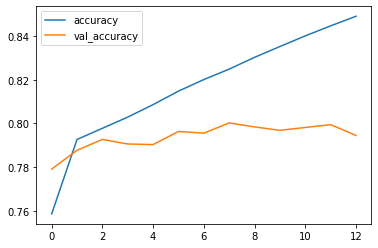

time: 344 ms (started: 2021-05-15 11:05:02 +05:30)


In [21]:
plot_graphs(history,'accuracy')

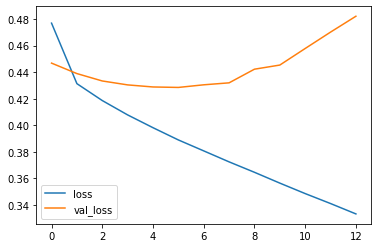

time: 156 ms (started: 2021-05-15 11:05:03 +05:30)


In [22]:
plot_graphs(history,'loss')

In [23]:
model.evaluate(test_dataset)

8125/8125 [==============================] - 110s 14ms/step - loss: 0.4715 - accuracy: 0.7978


[0.4714767634868622, 0.7978336811065674]

time: 2min (started: 2021-05-15 11:05:07 +05:30)


In [24]:
sample_text = ('amazing night!!!')
predictions = model.predict(np.array([sample_text]))
print(predictions)


[[4.592119]]
time: 7.64 s (started: 2021-05-15 11:07:08 +05:30)
